# Literature Review on Linear Optimal Low-Rank Projection (LOL)


## Introduction
In high-dimensional data analysis, reducing the number of dimensions is crucial for simplifying datasets while retaining important information. PCA is widely popular for this purpose; however, it has drawbacks. Vogelstein et al. (2021) argue that PCA, as an unsupervised technique, does not utilize class labels during low-dimensional transformation learning, often leading to suboptimal results for classification tasks. To address this limitation, Linear Optimal Low-Rank Projection (LOL) incorporates class-conditional moment estimates into the low-dimensional projection. This literature review will highlight LOL's advantages and performance compared to PCA based on Vogelstein et al.'s study. Additionally, information from LOL implementations on GitHub repositories will be incorporated.

## Class-Conditional Moments
Class-conditional moments are statistical properties (e.g., mean or variance) of data based on its class. The idea of LOL is that by incorporating the class-conditional moments in its calculations, LOL can create low-dimensional representations that better separate classes and retain important information for classification tasks.

## Implementation of LOL
Implementation of LOL involves the following steps:
1. Standardize the data.
2. Compute the sample mean for each class.
3. Estimate the difference between these class means.
4. Calculate the class-centered covariance matrix.
5. Perform eigenvalue decomposition on the covariance matrix (from step 4).
6. Create a projection matrix by combining the mean difference vector with the top eigenvectors of the class-centered covariance matrix.
7. Project the original data into lower-dimensional space using the projection matrix from step 6.

The GitHub repository provides implementations of LOL in Python and R.

## Suitable Datasets for LOL
The author states that LOL performs well for datasets with many features and relatively few samples, known as the 'large p small n' problem. Examples include biomedical datasets such as brain imaging and genomics data, where the number of features can reach millions while the number of samples remains in the hundreds. The paper implements LOL on brain imaging data with more than 150 million features and genomics data with over 500,000 features. Whenever possible, outliers should be removed from the dataset to prevent them from distorting the class-conditional moment estimates. Distorted class-conditional moment estimates may lead to reduced classification accuracy. Additionally, robust variants of LOL can be used if removing outliers is not feasible.

## Comparison of LOL and PCA
- LOL is supervised, meaning it considers class labels to create the projection, while PCA is unsupervised as it does not consider class labels.
- LOL combines class-conditional means and covariances, while PCA solely relies on the directions of maximum variance.
- LOL often achieves better classification accuracy than PCA, especially in datasets with high dimensionality and few samples.

## Results of Implementing LOL in the Study
Vogelstein et al. (2021) demonstrate that LOL outperforms PCA in classification accuracy using brain imaging data with 150 million features. LOL reduces dimensionality from 150 million to 200-300 dimensions and achieves a misclassification rate of 5-15%, surpassing PCA, which requires significantly more dimensions to achieve comparable accuracy. When evaluating performance using Cohen’s Kappa, LOL consistently shows higher values than PCA. Moreover, LOL incurs no significant additional computational cost over PCA.

## References
- Vogelstein, J. T., Bridgeford, E. W., Tang, M., Zheng, D., Douville, C., Burns, R., & Maggioni, M. (2021). Supervised dimensionality reduction for big data. *Nature Communications, 12*, 2872. https://doi.org/10.1038/s41467-021-23102-2
- NeuroData. (n.d.). Linear Optimal Low-Rank Projection (LOL). Retrieved from https://github.com/neurodata/lollipop

## Implementation of LOL

In [10]:
# pip install lolP

In [11]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.utils import resample
from lol import LOL
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [12]:
data = pd.read_csv('cleaned_health.csv')
data.head()

,AGE,GENDER,ETHNICITY,HEART_RATE,TEMPERATURE,RESP_RATE,ALBUMIN,BUN,BILIRUBIN,LACTATE,...,GLUCOSE,HEMOGLOBIN,HEMATOCRIT,PLATELET_COUNT,POTASSIUM,PTT,SODIUM,WBC,HOSPITAL_EXPIRE_FLAG,mahalanobis
0,77.0,M,OTHER,74.250,98.1125,18.375,3.1500,33.375000,0.60,1.300000,...,105.250000,15.47500,49.75000,169.0000,4.000,75.287500,141.875,9.5625,0,5.471652
1,85.0,F,WHITE,77.625,97.3875,12.250,2.7875,25.400000,0.90,1.483333,...,120.600000,12.27500,37.45000,311.2500,3.940,43.066667,142.600,9.1500,1,4.421819
2,44.0,F,OTHER,103.750,98.5125,20.625,2.6000,22.250000,0.25,1.610000,...,98.250000,7.73750,26.21250,496.7500,4.575,32.000000,139.500,17.9750,0,4.472636
3,91.0,F,WHITE,69.625,97.3625,17.750,3.1500,16.833333,0.60,1.550000,...,94.083333,11.03125,30.93125,212.8125,3.875,36.700000,133.500,7.7125,0,3.193359
4,63.0,M,WHITE,81.625,98.2750,25.625,3.1500,29.500000,0.50,2.450000,...,129.250000,11.18750,30.02500,218.9375,4.325,31.171429,140.125,11.3000,0,3.683406


In [13]:
data['HOSPITAL_EXPIRE_FLAG'].value_counts()

0    19286
1     3279
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64

As we can see, the target feature is heavily imbalanced. To address this problem we will do random under sampling before performing PCA or LOL.

In [14]:
X = data.drop(columns=['GENDER', 'ETHNICITY', 'HOSPITAL_EXPIRE_FLAG', 'mahalanobis']).values
y = data['HOSPITAL_EXPIRE_FLAG'].values

In [15]:
# Undersample to balance the classes
majority_class = y == 0
minority_class = y == 1

majority_class_data = data[majority_class]
minority_class_data = data[minority_class]

majority_class_downsampled = resample(majority_class_data, 
                                      replace=False, 
                                      n_samples=len(minority_class_data), 
                                      random_state=42)

balanced_data = pd.concat([majority_class_downsampled, minority_class_data])
X_balanced = balanced_data.drop(columns=['GENDER', 'ETHNICITY', 'HOSPITAL_EXPIRE_FLAG', 'mahalanobis']).values
y_balanced = balanced_data['HOSPITAL_EXPIRE_FLAG'].values


We split the data into training and test sets and standardize the data. We also initialize the cross validation condition.

In [16]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

We write a function to compute metrics to evaluate the performance for both LOL and PCA.

In [17]:
def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    misclassification_rate = 1 - accuracy
    kappa = cohen_kappa_score(y_true, y_pred)
    return accuracy, precision, recall, f1, misclassification_rate, kappa

pca_metrics = []
lol_metrics = []

We run PCA on the cleaned MIMIC_IV dataset. To be consistent the paper, we also use LDA as the classifier.

In [18]:
# Run PCA with CV
pca = PCA(n_components=min(X_train.shape))
X_train_pca = pca.fit_transform(X_train)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
explained_variance = pca.explained_variance_ratio_

for n_components in range(1, min(X_train.shape[1], 100)+1):
    lda = LDA()
    metrics_list = []

    for train_idx, test_idx in kfold.split(X_train_pca[:, :n_components], y_train):
        lda.fit(X_train_pca[train_idx, :n_components], y_train[train_idx])
        y_pred = lda.predict(X_train_pca[test_idx, :n_components])
        metrics_list.append(compute_metrics(y_train[test_idx], y_pred))
    
    avg_metrics = np.mean(metrics_list, axis=0)
    pca_metrics.append((n_components, cumulative_variance[n_components-1], *avg_metrics))

# Convert to DataFrame
pca_df = pd.DataFrame(pca_metrics, columns=['n_components', 'cumulative_variance', 'accuracy', 'precision', 'recall', 'f1', 'misclassification_rate', 'kappa'])


In [19]:
# Adjust pandas display settings
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Set display width to prevent wrapping

# Display the PCA DataFrame
pca_df = pca_df.iloc[:23]
pca_df

,n_components,cumulative_variance,accuracy,precision,recall,f1,misclassification_rate,kappa
0,1,0.158516,0.720479,0.757486,0.648366,0.698577,0.279521,0.440959
1,2,0.259082,0.731808,0.750489,0.694553,0.721350,0.268192,0.463617
2,3,0.351846,0.756645,0.796583,0.689760,0.739283,0.243355,0.513290
3,4,0.430966,0.777342,0.818432,0.712854,0.761970,0.222658,0.554684
4,5,0.508682,0.776688,0.819480,0.709804,0.760678,0.223312,0.553377
5,6,0.568345,0.775599,0.817285,0.709804,0.759737,0.224401,0.551198
6,7,0.623809,0.783224,0.818472,0.728105,0.770490,0.216776,0.566449
7,8,0.672968,0.786928,0.827466,0.725490,0.772914,0.213072,0.573856
8,9,0.720550,0.790632,0.827863,0.734205,0.778106,0.209368,0.581264
9,10,0.764962,0.787364,0.821907,0.734205,0.775387,0.212636,0.574728


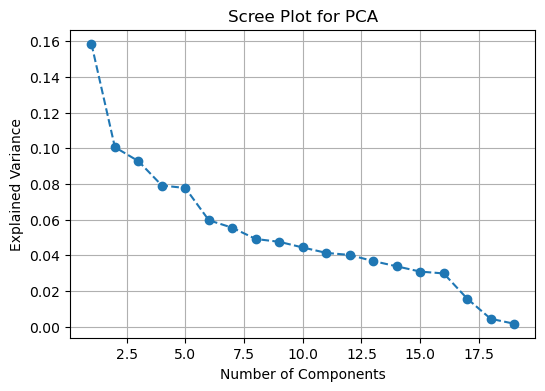

In [20]:
# Plot scree plot for PCA
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Scree Plot for PCA')
plt.grid(True)
plt.show()

Now we run LOL with cross-validation for the same cleaned MIMIC_IV dataset. To be consistent the paper, we also use LDA as the classifier.

In [21]:
# Run LOL with CV
for n_components in range(1, min(X_train.shape[1], 100)+1):
    lol = LOL(n_components=n_components)
    X_train_lol = lol.fit_transform(X_train, y_train)
    metrics_list = []

    for train_idx, test_idx in kfold.split(X_train_lol, y_train):
        lda = LDA()
        lda.fit(X_train_lol[train_idx], y_train[train_idx])
        y_pred = lda.predict(X_train_lol[test_idx])
        metrics_list.append(compute_metrics(y_train[test_idx], y_pred))
    
    avg_metrics = np.mean(metrics_list, axis=0)
    lol_metrics.append((n_components, *avg_metrics))


In [22]:
# Convert to DataFrame
lol_df = pd.DataFrame(lol_metrics, columns=['n_components', 'accuracy', 'precision', 'recall', 'f1', 'misclassification_rate', 'kappa'])

In [23]:
# Display the LOL DataFrame
lol_df = lol_df.iloc[:23]
lol_df

,n_components,accuracy,precision,recall,f1,misclassification_rate,kappa
0,1,0.780174,0.822085,0.715033,0.764793,0.219826,0.560349
1,2,0.780174,0.822085,0.715033,0.764793,0.219826,0.560349
2,3,0.800000,0.834971,0.748148,0.789070,0.200000,0.600000
3,4,0.794989,0.833670,0.737255,0.782413,0.205011,0.589978
4,5,0.800218,0.835505,0.747712,0.789123,0.199782,0.600436
5,6,0.801743,0.833037,0.755120,0.792053,0.198257,0.603486
6,7,0.801743,0.830725,0.758170,0.792728,0.198257,0.603486
7,8,0.803486,0.833597,0.758606,0.794256,0.196514,0.606972
8,9,0.801743,0.836034,0.751198,0.791227,0.198257,0.603486
9,10,0.802614,0.837624,0.751198,0.791930,0.197386,0.605229


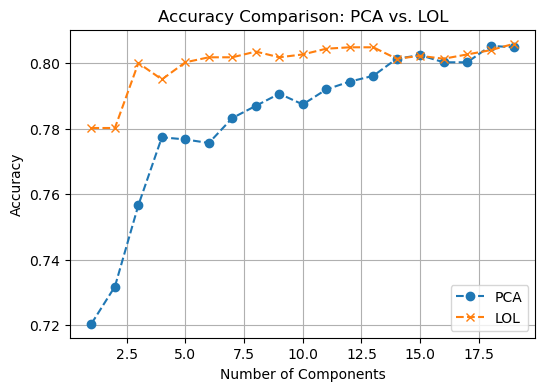

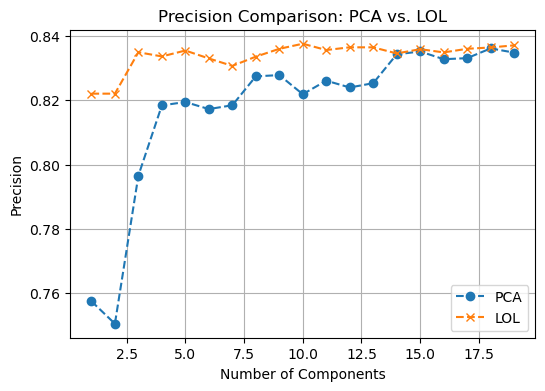

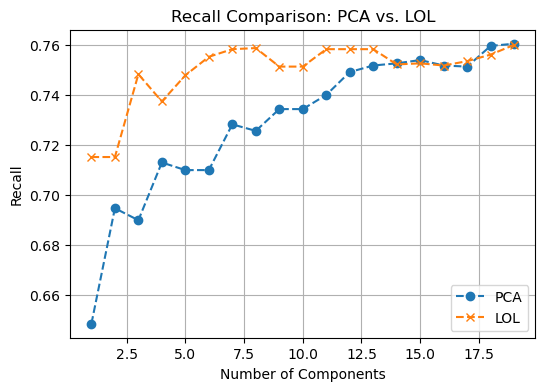

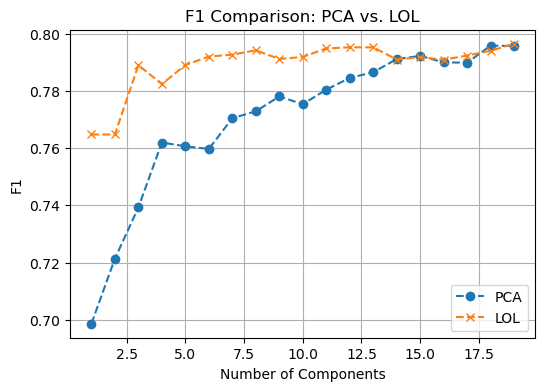

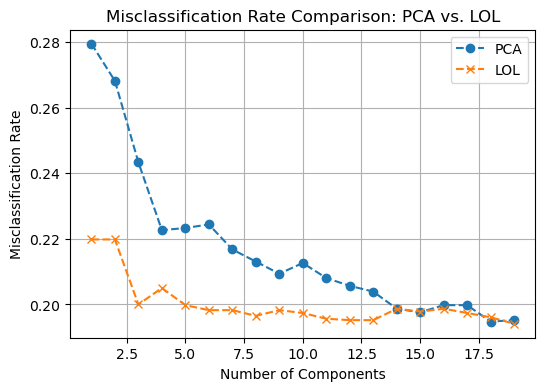

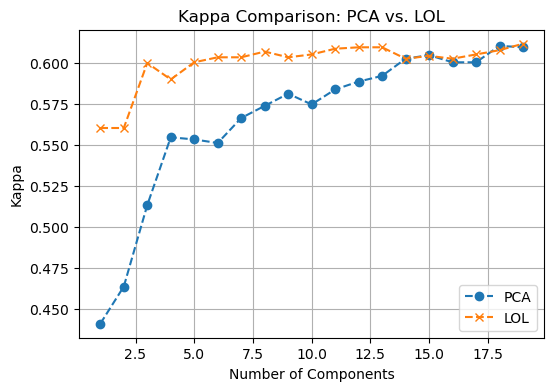

In [24]:
# Plot comparison graphs
def plot_comparison(pca_df, lol_df, metric):
    plt.figure(figsize=(6, 4))
    plt.plot(pca_df['n_components'], pca_df[metric], marker='o', linestyle='--', label='PCA')
    plt.plot(lol_df['n_components'], lol_df[metric], marker='x', linestyle='--', label='LOL')
    plt.xlabel('Number of Components')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f'{metric.replace("_", " ").title()} Comparison: PCA vs. LOL')
    plt.legend()
    plt.grid(True)
    plt.show()

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'misclassification_rate', 'kappa']
for metric in metrics_to_plot:
    plot_comparison(pca_df, lol_df, metric)

## Analysis and Interpretation

### Classification Rate and Cohen's Kappa

In their study, Vogelstein et al. (2021) used misclassification rate and Cohen's Kappa to compare the performance of LOL with PCA.

The misclassification rate is calculated as 1 - accuracy, and lower values are preferable.

Cohen's Kappa quantifies inter-rater agreement for categorical items, with higher values indicating better agreement.

### Performance Evaluation of LOL vs PCA

Initially, the dataset comprised 19 numerical features, transformed using both PCA and LOL. From the plots, LOL consistently demonstrates superior performance metrics (accuracy, precision, recall, F1 score, misclassification rate, and Cohen's Kappa) compared to PCA when using fewer than 13 features.

LOL achieves its highest accuracy of 80.34% with 8 components. In contrast, PCA achieves a maximum accuracy of 80.23% but requires 15 components, nearly double that of LOL.

In predicting ICU patient mortality, recall takes precedence over precision due to the high cost of missing at-risk patients.

Considering recall as a performance metric, PCA achieves a maximum recall of 75.38% with 15 components, whereas LOL achieves 75.86% with only 8 components.

The results of implementing LOL and PCA on the MIMIC IV dataset strongly support the study's conclusions: 1) LOL consistently outperforms PCA across evaluation metrics, and 2) PCA requires significantly more components to achieve comparable results.

Additionally, the computational time required for LOL and PCA in this Jupyter notebook is similar (less than 2 minutes), confirming that there is negligible difference in computational cost between the two methods.